In [1]:
import pickle
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip3 install statsmodels

In [3]:
!pip3 install pmdarima

In [4]:
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

In [5]:
df_risk_info = pd.read_csv('../df_risk_info_2021-12-11.csv')

In [6]:
with open('../stock_info_2021-12-11.pickle', 'rb') as handle:
    stock_info = pickle.load(handle)

with open('../stock_history_2021-12-11.pickle', 'rb') as handle:
    stock_history = pickle.load(handle)

In [7]:
ticker = "V"
stock_cols = ["Close", "ticker"]

In [8]:
df = stock_history[ticker]
df.index = df['Date']
df = df[stock_cols]
print(df.shape)

(756, 2)


In [9]:
df.head()

,Close,ticker
Date,,
2018-12-12,137.800003,V
2018-12-13,137.539993,V
2018-12-14,135.089996,V
2018-12-17,131.399994,V
2018-12-18,132.660004,V


In [10]:
df.tail()

,Close,ticker
Date,,
2021-12-06,202.679993,V
2021-12-07,207.369995,V
2021-12-08,208.990005,V
2021-12-09,211.389999,V
2021-12-10,213.399994,V


In [11]:
def test_stationarity(ts, window):
    
    # 주어진 window에 따라 Rolling statistics 계산
    rolmean = ts.rolling(window).mean()
    rolstd = ts.rolling(window).std()
    
    # Rolling statistics 그래프
    plt.figure(figsize=(8,4))
    plt.plot(ts, color='blue', label='Original')
    plt.plot(rolmean, color='red', label=f'Rolling Mean: {window}')
    plt.plot(rolstd, color='black', label=f'Rolling Std: {window}')
    plt.title(f'Rolling Mean and Standard Deviation: {window}')
    plt.legend(loc='best')
    plt.show()
    
    print("Dickey fuller 검정법 결과")
    adft = adfuller(ts, autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value',
                                         'No. of lags used', 'Number of observations used'])
    for key, values in adft[4].items():
        output['critical value (%s)'%key] = values
    print(output)
    print('\n----------------------------------------')
    print("귀무가설(H0): 주어진 시계열이 정상성을 가지지 않는다.")
    print("대립가설(H1): 주어진 시계열은 정상성을 갖는다.\n")
    
    # 가설 검정 결론 (유의수준 vs. p-value)
    p_val = round(output["p-value"],3)
    if output["p-value"] > 0.05:
        print(f"[결론] 유의수준(0.05) < p-value({p_val})이므로 귀무가설 채택(fail to reject)한다.")
        print(f"..... 주어진 시계열은 정상성을 가지지 않으므로 차분 작업 필요하다.")
    else:
        print(f"[결론] 유의수준(0.05) > p-value({p_val})이므로 귀무가설 기각(reject)한다.")
        print(f"..... 주어진 시계열은 정상성을 갖는다.")

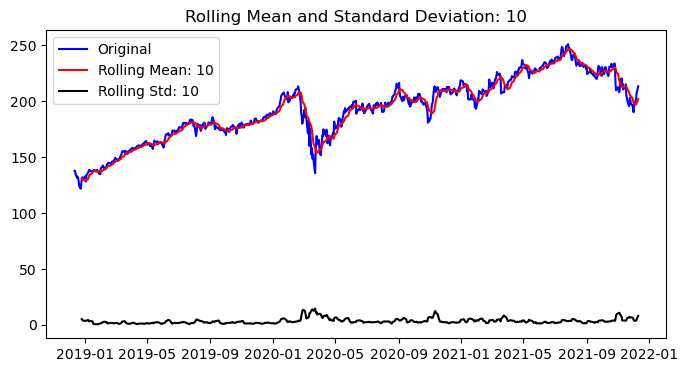

Dickey fuller 검정법 결과
Test Statistics                 -2.199808
p-value                          0.206315
No. of lags used                16.000000
Number of observations used    739.000000
critical value (1%)             -3.439230
critical value (5%)             -2.865459
critical value (10%)            -2.568857
dtype: float64

----------------------------------------
귀무가설(H0): 주어진 시계열이 정상성을 가지지 않는다.
대립가설(H1): 주어진 시계열은 정상성을 갖는다.

[결론] 유의수준(0.05) < p-value(0.206)이므로 귀무가설 채택(fail to reject)한다.
..... 주어진 시계열은 정상성을 가지지 않으므로 차분 작업 필요하다.


In [12]:
test_stationarity(df["Close"], 10)

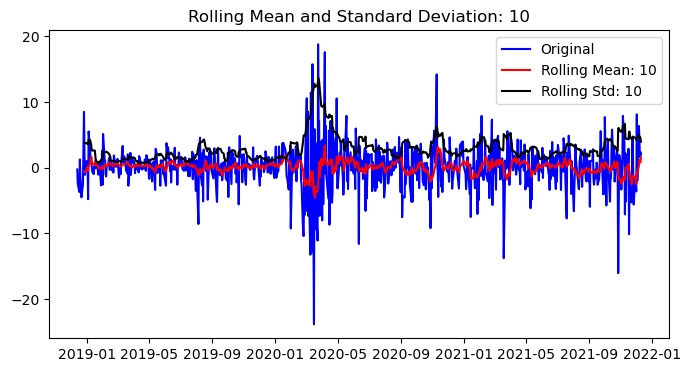

Dickey fuller 검정법 결과
Test Statistics               -6.504808e+00
p-value                        1.138156e-08
No. of lags used               1.500000e+01
Number of observations used    7.390000e+02
critical value (1%)           -3.439230e+00
critical value (5%)           -2.865459e+00
critical value (10%)          -2.568857e+00
dtype: float64

----------------------------------------
귀무가설(H0): 주어진 시계열이 정상성을 가지지 않는다.
대립가설(H1): 주어진 시계열은 정상성을 갖는다.

[결론] 유의수준(0.05) > p-value(0.0)이므로 귀무가설 기각(reject)한다.
..... 주어진 시계열은 정상성을 갖는다.


In [13]:
# d=1 로 1차분 했을 때 정상성 확인

df["Close_diff"] = df["Close"].diff()
df.dropna(inplace=True)

test_stationarity(df["Close_diff"], 10)

In [14]:
model_autoARIMA = auto_arima(df['Close'])

In [15]:
model_autoARIMA = auto_arima(df['Close'],
                             start_p=0, start_q=0, # p, q 시작값
                             max_p=3, max_q=3,     # p and q 최댓값
                             test='adf',           # adf를 통해 d 계산
                             d=None,               # 모델을 통해 d 지정
                             m=1,                  # 연(year)간 데이터
                             seasonal=False,       # 계절성 없음
                             trace=True,           # 값 보여줌
                             with_intercept='auto',# 상수 자동으로 포함/비포함 결정
                             stepwise=True         # p, q 조합으로 진행
                            )
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4033.165, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4017.329, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4019.236, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4031.788, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4017.191, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4019.127, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4019.179, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4017.740, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4016.062, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4012.726, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3980.722, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4018.725, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3982.690, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4007.307, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

In [16]:
# 모델 진단

In [ ]:
model_autoARIMA.plot_diagnostics(figs